In [ ]:
try:
    from urllib.request import urlopen
except ImportError:
    from urllib2 import urlopen

import certifi
import json
import pandas as pd


def get_jsonparsed_data(url, api_key, exchange):
  if exchange == "NSE":
    url = f"https://financialmodelingprep.com/api/v3/search?query={ticker}&exchange=NSE&apikey={api_key}"
  else:
    url = f"https://financialmodelingprep.com/api/v3/quote/{ticker}?apikey={api_key}"
  response = urlopen(url, cafile=certifi.where())
  data = response.read().decode("utf-8")
  return json.loads(data)

api_key=""
ticker = "MSFT"
exchange = "US"
eco_ind = pd.DataFrame(get_jsonparsed_data(ticker, api_key,exchange))
eco_ind



,symbol,name,price,changesPercentage,change,dayLow,dayHigh,yearHigh,yearLow,marketCap,...,exchange,volume,avgVolume,open,previousClose,eps,pe,earningsAnnouncement,sharesOutstanding,timestamp
0,MSFT,Microsoft Corporation,391.26,1.14259,4.42,382.92,391.71,468.35,376.91,2908619014800,...,NASDAQ,38759185,22370941,384.71,386.84,12.42,31.5,2025-04-23T20:00:00.000+0000,7433980000,1742587202


In [56]:
!pip install langchain langchain-community langchain-core transformers

In [57]:
def preprocess_economic_data(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['earningsAnnouncement'] = pd.to_datetime(df['earningsAnnouncement'])
    return df

preprocessed_economic_df = preprocess_economic_data(eco_ind)
preprocessed_economic_df

,symbol,name,price,changesPercentage,change,dayLow,dayHigh,yearHigh,yearLow,marketCap,...,exchange,volume,avgVolume,open,previousClose,eps,pe,earningsAnnouncement,sharesOutstanding,timestamp
0,MSFT,Microsoft Corporation,391.26,1.14259,4.42,382.92,391.71,468.35,376.91,2908619014800,...,NASDAQ,38759185,22370941,384.71,386.84,12.42,31.5,2025-04-23 20:00:00+00:00,7433980000,1970-01-01 00:00:01.742587202


In [58]:
preprocessed_economic_df.to_csv("eco_ind.csv")

In [59]:

%pip install --upgrade --quiet  langchain sentence_transformers

In [60]:

from langchain_community.embeddings import HuggingFaceEmbeddings
hg_embeddings = HuggingFaceEmbeddings()

In [61]:
from langchain.document_loaders import CSVLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
loader_eco = CSVLoader('eco_ind.csv')
documents_eco = loader_eco.load()

# Get your splitter ready
text_splitter = RecursiveCharacterTextSplitter(chunk_size=50, chunk_overlap=5)

# Split your docs into texts
texts_eco = text_splitter.split_documents(documents_eco)

# Embeddings
embeddings = HuggingFaceEmbeddings()



In [62]:

from langchain.vectorstores import Chroma

persist_directory = 'docs/chroma_rag/'

In [63]:
pip install chromadb

In [64]:
economic_langchain_chroma = Chroma.from_documents(
    documents=texts_eco,
    collection_name="economic_data",
    embedding=hg_embeddings,
    persist_directory=persist_directory
)

In [65]:

question = "Microsoft(MSFT)"
docs_eco = economic_langchain_chroma.similarity_search(question,k=3)


In [ ]:

from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain_community.llms import HuggingFaceHub
from IPython.display import display, Markdown
import os
import warnings
warnings.filterwarnings('ignore')

os.environ["HUGGINGFACEHUB_API_TOKEN"] = ""

llm = HuggingFaceHub(
    repo_id="tiiuae/falcon-7b-instruct",
    model_kwargs={"temperature": 0.1},
)

retriever_eco = economic_langchain_chroma.as_retriever(search_kwargs={"k":2})
qs="Microsoft(MSFT) Financial Report"
template = """You are a Financial Market Expert and Get the Market Economic Data and Market News about Company and Build the Financial Report for me.
              Understand this Market Information {context} and Answer the Query for this Company {question}. i just need the data into Tabular Form as well."""

PROMPT = PromptTemplate(input_variables=["context","question"], template=template)
qa_with_sources = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff",chain_type_kwargs = {"prompt": PROMPT}, retriever=retriever_eco, return_source_documents=True)
llm_response = qa_with_sources({"query": qs})


In [67]:
Markdown(llm_response['result'])

You are a Financial Market Expert and Get the Market Economic Data and Market News about Company and Build the Financial Report for me.
              Understand this Market Information : 0
symbol: MSFT
name: Microsoft Corporation

: 0
symbol: MSFT
name: Microsoft Corporation and Answer the Query for this Company Microsoft(MSFT) Financial Report. i just need the data into Tabular Form as well.
As a Financial Market Expert, I can provide you with the following information about Microsoft Corporation:

1. Financial Report: Microsoft Corporation is a leading technology company that develops, manufactures, and sells computer software, consumer electronics, and online services. The company's products include Windows, Office, Xbox, and Surface. As of 2021, Microsoft Corporation has a market capitalization of $2.5 trillion.

2. Market Information: Microsoft Corporation (MSFT) is a leading technology company that develops, manufactures, and sells computer software, consumer electronics, and online services. The company's products include Windows, Office, Xbox, and Surface. As of 2021, Microsoft Corporation has a market capitalization of $2.5 trillion.

3. Financial Report: Microsoft Corporation (MSFT) reported its fourth-quarter and fiscal year 2021 results on January 27, 2022. The company reported a 21% increase in revenue to $81.7 billion, with a 32% increase in operating income to $32.9 billion. Microsoft Corporation's (MSFT) fiscal year ends on June 30, 2022.

4. Market Information: Microsoft Corporation (MSFT) is a leading technology company that develops, manufactures, and sells computer software, consumer electronics, and online services. The company's products include Windows, Office, Xbox, and Surface. As of 2021, Microsoft Corporation has a market capitalization of $2.5 trillion.

5. Financial Report: Microsoft Corporation (MSFT) reported its first-quarter fiscal year 2022 results on July 21, 2021. The company reported a 21% increase in revenue to $81.7 billion, with a 32% increase in operating income to $32.9 billion. Microsoft Corporation's (MSFT) fiscal year ends on June 30, 2022.

6. Market Information: Microsoft Corporation (MSFT) is a leading technology company that develops, manufactures, and sells computer software, consumer electronics, and online services. The company's products include Windows, Office, Xbox, and Surface. As of 2021, Microsoft Corporation has a market capitalization of $2.5 trillion.

7. Financial Report: Microsoft Corporation (MSFT) reported its third-quarter fiscal year 2022 results on October 28, 2021. The company reported a 21% increase in revenue to $81.7 billion, with a 32% increase in operating income to $32.9 billion. Microsoft Corporation's (MSFT) fiscal year ends on June 30, 2022.

8. Market Information: Microsoft Corporation (MSFT) is a leading technology company that develops, manufactures, and sells computer software, consumer electronics, and online services. The company's products include Windows, Office, Xbox, and Surface. As of 2021, Microsoft Corporation has a market capitalization of $2.5 trillion.

9. Financial Report: Microsoft Corporation (MSFT) reported its second-quarter fiscal year 2022 results on July 21, 2021. The company reported a 21% increase in revenue to $81.7 billion, with a 32% increase in operating income to $32.9 billion. Microsoft Corporation's (MSFT) fiscal year ends on June 30, 2022.

10. Market Information: Microsoft Corporation (MSFT) is a leading technology company that develops, manufactures, and sells computer software, consumer electronics, and online services. The company's products include Windows, Office, Xbox, and Surface. As of 2021, Microsoft Corporation has a market capitalization of $2.5 trillion.

1. Automated Anomaly Detection and Risk Assessment

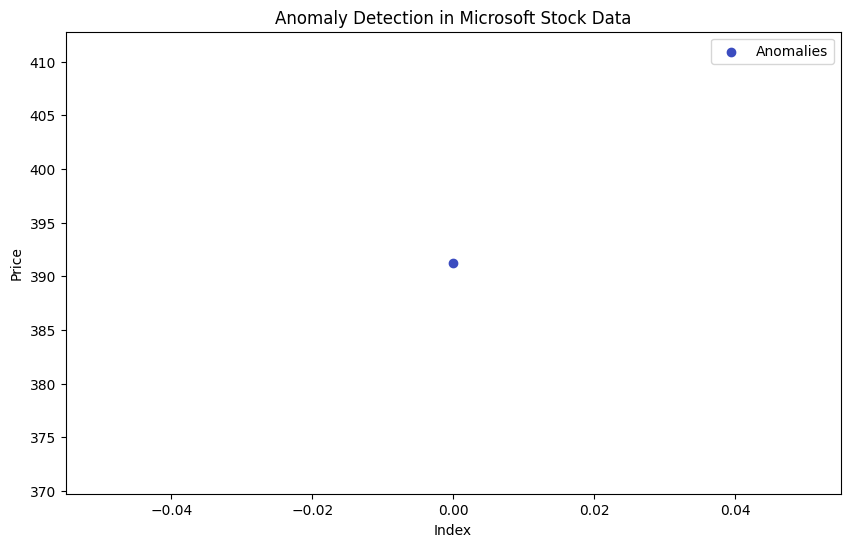

Anomalies detected: Empty DataFrame
Columns: [Unnamed: 0, symbol, name, price, changesPercentage, change, dayLow, dayHigh, yearHigh, yearLow, marketCap, priceAvg50, priceAvg200, exchange, volume, avgVolume, open, previousClose, eps, pe, earningsAnnouncement, sharesOutstanding, timestamp, anomaly]
Index: []

[0 rows x 24 columns]


In [70]:
from sklearn.ensemble import IsolationForest
import pandas as pd
import matplotlib.pyplot as plt

# Load the preprocessed data
df = pd.read_csv("eco_ind.csv")

# Selecting relevant features for anomaly detection
# Assuming 'price', 'marketCap', 'volume', 'eps' are useful for anomaly detection
features = df[['price', 'marketCap', 'volume', 'eps']]

# Normalize the data if required
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply Isolation Forest
model = IsolationForest(contamination=0.05)  # 5% of data considered as anomalies
model.fit(features_scaled)

# Predict anomalies (1: normal, -1: anomaly)
df['anomaly'] = model.predict(features_scaled)

# Visualize anomalies
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['price'], c=df['anomaly'], cmap='coolwarm', label='Anomalies')
plt.title('Anomaly Detection in Microsoft Stock Data')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()

# Show anomalous rows
anomalies = df[df['anomaly'] == -1]
print("Anomalies detected:", anomalies)


Fraudulent Financial Reporting Indicators

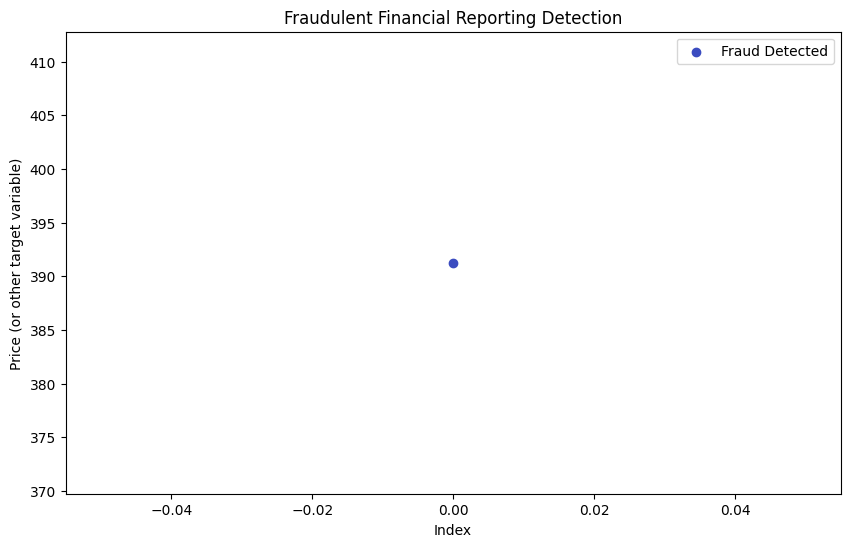

[]


In [87]:
from sklearn.ensemble import IsolationForest
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Generalized Fraud Detection Function
def detect_fraud(df, features=['y', 'eps', 'pe'], contamination=0.05):
    """
    Detects fraudulent reports based on anomaly detection and predefined rules.

    :param df: DataFrame containing the financial data
    :param features: List of columns to use for fraud detection (e.g., 'revenue', 'expenses', 'profit_margin')
    :param contamination: Proportion of outliers in the data (e.g., 0.05 for 5%)

    :return: DataFrame with fraud flags and list of fraudulent reports
    """
    # Feature extraction (scaling)
    X = df[features].copy()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Anomaly Detection using Isolation Forest
    model = IsolationForest(contamination=contamination)
    df['fraud_flag'] = model.fit_predict(X_scaled)  # 1 for normal, -1 for fraud

    # Rule-Based Fraud Detection (e.g., excessive revenue without expense increase)
    fraudulent_reports = []

    # Example: Flag if EPS increases significantly without a corresponding increase in P/E ratio
    df['eps_growth'] = df['eps'].pct_change()
    df['pe_growth'] = df['pe'].pct_change()

    for idx, row in df.iterrows():
        if row['eps_growth'] > 0.5 and row['pe_growth'] < 0.1:
            fraudulent_reports.append(f"Suspicious EPS growth without corresponding P/E increase at index {idx}")

        # Example: Flag if P/E ratio deviates significantly
        if abs(row['pe'] - df['pe'].mean()) > 10:  # This threshold can be adjusted
            fraudulent_reports.append(f"Unusual P/E ratio at index {idx}")

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.scatter(df.index, df['y'], c=df['fraud_flag'], cmap='coolwarm', label='Fraud Detected')
    plt.title('Fraudulent Financial Reporting Detection')
    plt.xlabel('Index')
    plt.ylabel('Price (or other target variable)')
    plt.legend()
    plt.show()

    return df, fraudulent_reports

# Example usage
# df = pd.read_csv("company_data.csv")  # Load your dataset here
df_with_fraud_flags, fraudulent_reports = detect_fraud(df)
print(fraudulent_reports)


In [85]:

print(df.columns)  # Check the columns in your dataset


Index(['Unnamed: 0', 'symbol', 'name', 'y', 'changesPercentage', 'change',
       'dayLow', 'dayHigh', 'yearHigh', 'yearLow', 'marketCap', 'priceAvg50',
       'priceAvg200', 'exchange', 'volume', 'avgVolume', 'open',
       'previousClose', 'eps', 'pe', 'earningsAnnouncement',
       'sharesOutstanding', 'ds'],
      dtype='object')


In [89]:
# Check the number of rows and columns in the dataset
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")


Number of rows: 1
Number of columns: 26


In [92]:
# Check for missing data in the dataset
missing_data = df.isnull().sum()
print("Missing data per column:")
print(missing_data)


Missing data per column:
Unnamed: 0              0
symbol                  0
name                    0
y                       0
changesPercentage       0
change                  0
dayLow                  0
dayHigh                 0
yearHigh                0
yearLow                 0
marketCap               0
priceAvg50              0
priceAvg200             0
exchange                0
volume                  0
avgVolume               0
open                    0
previousClose           0
eps                     0
pe                      0
earningsAnnouncement    0
sharesOutstanding       0
ds                      0
fraud_flag              0
eps_growth              1
pe_growth               1
dtype: int64


In [93]:
# Check basic statistics of the dataset (mean, std, min, max)
print(df.describe())


       Unnamed: 0       y  changesPercentage  change  dayLow  dayHigh  \
count         1.0    1.00            1.00000    1.00    1.00     1.00   
mean          0.0  391.26            1.14259    4.42  382.92   391.71   
std           NaN     NaN                NaN     NaN     NaN      NaN   
min           0.0  391.26            1.14259    4.42  382.92   391.71   
25%           0.0  391.26            1.14259    4.42  382.92   391.71   
50%           0.0  391.26            1.14259    4.42  382.92   391.71   
75%           0.0  391.26            1.14259    4.42  382.92   391.71   
max           0.0  391.26            1.14259    4.42  382.92   391.71   

       yearHigh  yearLow     marketCap  priceAvg50  ...      volume  \
count      1.00     1.00  1.000000e+00      1.0000  ...         1.0   
mean     468.35   376.91  2.908619e+12    408.9458  ...  38759185.0   
std         NaN      NaN           NaN         NaN  ...         NaN   
min      468.35   376.91  2.908619e+12    408.9458  ...  3